# Setup
Using data from [CSNMR-2982_whip_permutations](https://drive.google.com/drive/folders/1cWvEboCfpwcht5SAhj9iu9lox-VMRJ0f?usp=drive_link)

All 3 receivers were on the Westminster Building #2 roof, with microwave absorbing foam under them.

The Z3R was a Zepher 3 Rover antenna into a BX99x receiver.

The Klondike was a bare Klondike element into a BX99x receiver.

The P3ENCL was a Judo Prototype 3 enclosure, with 2x Klondike elements in it, but nothing else. The RF outputs of the Klondike elements were run to a BX992 receiver.

The results shown here are all for the primary antenna input to the BX receivers.

# Imports

In [72]:
%load_ext autoreload
%autoreload 2 

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import os

#import viewdat_cno_lib as vdl
import montera.pos_lib as pos_lib
import montera.all_pos_summary as aps
import montera.gutil as gutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [3]:
# This class was brazenly stolen from mutils.py in the Sunnyvale CVS repo
class OrbitConst(object):
    """
    Orbital constants
    """
    PI = 3.14159265358979323846
    A_WGS84 = 6378137.0
    B_WGS84 = 6356752.314245179
    E2_WGS84 = 6.69437999013e-3
    ONE_MIN_E2 = 0.99330562000987
    SQRT_ONE_MIN_E2 = 9.96647189335258e-1


# This function was brazenly stolen from mutils.py in the Sunnyvale CVS repo
def llh2enu(llh, ref_llh, is_rad=False, is_ref_rad=False):
    """
    Convert lat/lon/height to delta east/north/up.
    llh = array of lat/lon/height [lat/lon in degrees by default]
    ref_llh = point or array of lat/lon/height [lat/lon in degrees by default]
    is_rad = True -> "llh" lat/lon is radians, else in degrees
    is_ref_rad = True -> "ref_llh" lat/lon is radians, else in degrees
    """
    # Make sure inputs are arrays
    if len(np.shape(llh)) == 1:
        llh = llh.reshape((1, len(llh)))
    if len(np.shape(ref_llh)) == 1:
        ref_llh = ref_llh.reshape((1, len(ref_llh)))

    # Convert to radians?
    scale1 = np.ones(np.shape(llh))
    scale2 = np.ones(np.shape(ref_llh))
    ref_lat = np.copy(ref_llh[:, 0])
    if not is_rad:
        scale1[:, 0:2] *= OrbitConst.PI/180
    if not is_ref_rad:
        scale2[:, 0:2] *= OrbitConst.PI/180
        ref_lat *= OrbitConst.PI/180

    # Compute the residuals
    dllh = llh*scale1 - ref_llh*scale2

    # Compute Radii of Curvature
    W = np.sqrt(1 - OrbitConst.E2_WGS84 * np.sin(ref_lat)**2)
    N = OrbitConst.A_WGS84 / W
    M = OrbitConst.A_WGS84 * (1 - OrbitConst.E2_WGS84) / W**3

    # Compute Metric Components
    dE = dllh[:, 1] * N * np.cos(ref_lat)
    dN = dllh[:, 0] * M
    dU = dllh[:, 2]

    return (dE, dN, dU)


# Read Files

To create the csv files, the following commands were run, with the [montera]() utility `pos_in_one_stats`


    pos_in_one_stats 240312_no_whips KLONDIKE
    pos_in_one_stats 240312_no_whips Z3R
    pos_in_one_stats 240312_no_whips P3ENCL


In [4]:
data_dir = '240312_no_whips'
days = [
    #_240311_both_whips_wrong_ant_model
    '240312_no_whips',
    #'240312_no_whips_short'.
    '240313_whip_uhf',
    '_240314_whip_halow_snow,'
_240315_whip_halow_snow
240317_whip_halow
240318_whip_both
240319_900only_halow
240320_900only_uhf
240322_450only_uhf
240323_450only_uhf
240324_450only_uhf
_240325_remote_940mm
240326_remote_940mm
240327_remote_940mm
240328_remote_940mm
240329_remote_940mm
240330_remote_310mm
240331_remote_310mm
240401_remote_310mm
_240402_remote_310mm

devs = ['KLONDIKE', 'P3ENCL', 'Z3R']
df = pd.DataFrame([])
for day in days:
    for dev in devs:
        df_this = pd.read_csv(f'{data_dir}/gen_data/position/{name}/{name}_pos_weighted_stats.csv')
        df_this['name'] = name
        df_this = df_this.query('antenna == 0')
        df_this = df_this.drop(['std_err', 'std_err_hprec', 'std_err_vprec', 'count'], axis=1)
        
        df = pd.concat([df, df_this], axis=0)
        #print(name)
        #display(df_this)

print('summary --------------')
display(df)

#df_ref = pd.read_csv(f'240312_no_whips/gen_data/position/Z3R/Z3R_pos_weighted_stats.csv')
#df_ref['name'] = 'REF'
#df_ref = df.drop(['std_err', 'std_err_hprec', 'std_err_vprec', 'count')

summary --------------


Empty DataFrame
Columns: [antenna, w_mean_lat, w_mean_lon, w_mean_hgt, datum, datum_epoch, name]
Index: []

In [26]:
df.to_csv('CSNMR-2982_mean_positions.csv', index=False);

# Read Summary

In [48]:
#df = df_heading.merge(df_w_mean, how='outer', on=['day', 'dev', 'data_type'])
def merge_heading_wpos(df_w_mean, df_heading):
    heading = []
    for n_row, row in df_w_mean.iterrows():
        data_type = row.data_type.strip()
        q = f'day=="{row.day}" and dev=="{row.dev}" and data_type=="{data_type}"'
        print(f'{q=}')
        dfq = df_heading.query(q)
        if dfq.empty:
            h = np.nan
        else:
            h = float(dfq.heading_mean.iloc[0])
        heading.append(h)
    df_w_mean['heading_mean'] = heading
    return df_w_mean

In [207]:
df_heading = pd.read_csv('all_pos_summary_heading.csv')
df_heading = df_heading.rename({'dut':'dev'}, axis='columns')
#display(df_heading) #.query('dev=="P3ENCL-all"'))
#print(df_heading.columns)

df_w_mean = pd.read_csv('all_pos_summary_weighted_stats.csv')
#display(df_w_mean.query('dev=="P3ENCL-all"'))
#print(df_w_mean.columns)

## Data Frame Merge, and add numeric columns, etc

In [214]:
df_heading = pd.read_csv('gen_data/all_pos_summary_heading.csv')
df_heading = df_heading.rename({'dut':'dev'}, axis='columns')
df_w_mean = pd.read_csv('gen_data/all_pos_summary_weighted_stats.csv')

# Combine Headings and positions 
df = merge_heading_wpos(df_w_mean, df_heading)
#df['heading'] = heading

#df_p3 = df.query('dev=="P3ENCL-all"')
#display(df_p3)

# Numeric version of 'position', 'titan-position', etc
df['n_dt'] = pd.factorize(df['data_type'])[0]

# Convert heading to a compass direction
def degrees_to_compass(degrees):
    if 0 <= degrees < 45 or degrees >= 315:
        return 'N'
    elif 45 <= degrees < 135:
        return 'E'
    elif 135 <= degrees < 225:
        return 'S'
    elif 225 <= degrees < 315:
        return 'W'
    return 'none'
df['compass_dir'] = df['heading_mean'].apply(degrees_to_compass)

# Stript date out of day, to create a description
def day2descr(day):
    descr = '_'.join(day.split('_')[1:])
    return descr

df['descr'] = df['day'].apply(day2descr)
df = df.query('day != "240312_no_whips_short"')
df = df.query('dev == "P3ENCL-all"')

display(df)

day         dev       data_type  antenna  w_mean_lat  \
0       240312_no_whips  P3ENCL-all        position        0   39.896468   
1       240312_no_whips  P3ENCL-all        position        1   39.896467   
2       240312_no_whips  P3ENCL-all  titan-position        0   39.896473   
3       240312_no_whips  P3ENCL-all  titan-position        1   39.896472   
6       240313_whip_uhf  P3ENCL-all        position        0   39.896468   
..                  ...         ...             ...      ...         ...   
61  240331_remote_310mm  P3ENCL-all  titan-position        1   39.896472   
62  240401_remote_310mm  P3ENCL-all        position        0   39.896468   
63  240401_remote_310mm  P3ENCL-all        position        1   39.896467   
64  240401_remote_310mm  P3ENCL-all  titan-position        0   39.896473   
65  240401_remote_310mm  P3ENCL-all  titan-position        1   39.896472   

    w_mean_lon   w_mean_hgt   std_err  std_err_hprec  std_err_vprec  ...  \
0  -105.115056  1668.524142  0.023233       0.004582       0.010636  ...   
1  -105.115056  1668.527233  0.007273       0.002102       0.002264  ...   
2  -105.115071  1667.626456  0.023029       0.307111       0.603853  ...   
3  -105.115071  1667.622218  0.007537       0.002464       0.002948  ...   
6  -105.115056  1668.522656  0.021217       0.004233       0.009555  ...   
..         ...          ...       ...            ...            ...  ...   
61 -105.115071  1667.625198  0.007564       0.002503       0.003133  ...   
62 -105.115056  1668.524331  0.021377       0.004286       0.009911  ...   
63 -105.115056  1668.529135  0.007386       0.002123       0.002310  ...   
64 -105.115071  1667.627436  0.021787       0.015719       0.027847  ...   
65 -105.115071  1667.624575  0.007599       0.002459       0.003064  ...   

     datum datum_epoch      northing       easting            up  comments  \
0   WGS-84         0.0 -3.531454e-09  1.414450e-08  3.865352e-12       NaN   
1   WGS-84         0.0  3.531454e-09  2.720096e-08 -9.094947e-13       NaN   
2      NaN         NaN  1.412582e-09  1.088038e-09 -6.821210e-13       NaN   
3      NaN         NaN  7.062908e-10  0.000000e+00  6.821210e-13       NaN   
6   WGS-84         0.0 -1.195531e-03 -1.329398e-04 -1.486714e-03       NaN   
..     ...         ...           ...           ...           ...       ...   
61     NaN         NaN -1.529279e-03 -1.012383e-03  2.979308e-03       NaN   
62  WGS-84         0.0 -1.189635e-03  4.708932e-04  1.885426e-04       NaN   
63  WGS-84         0.0 -9.355005e-04 -2.212091e-05  1.902577e-03       NaN   
64     NaN         NaN -9.493890e-04 -5.366890e-04  9.795787e-04       NaN   
65     NaN         NaN -6.824393e-04 -1.040246e-03  2.356946e-03       NaN   

    heading_mean  n_dt  compass_dir         descr  
0       1.359880     0            N      no_whips  
1       1.359880     0            N      no_whips  
2       1.410764     1            N      no_whips  
3       1.410764     1            N      no_whips  
6       1.379091     0            N      whip_uhf  
..           ...   ...          ...           ...  
61      1.675777     1            N  remote_310mm  
62      1.734999     0            N  remote_310mm  
63      1.734999     0            N  remote_310mm  
64      1.770880     1            N  remote_310mm  
65      1.770880     1            N  remote_310mm  

[64 rows x 21 columns]

## Read Summary Plots

In [288]:
#from matplotlib.markers import MarkerStyle
data_types = list(df.data_type.unique())
#fillstyle_map = {
#    'N': 'top',
#    'E': 'right',
#    'S': 'bottom',
#    'W': 'left',
#    'none':'none',
#}
marker_list = [#'.', ',', 
               'o', 'v', '^', '<', '>', 's', 'p', '*', 'D', 'h', 'H', 'P', 'X', 'd']
               #'+', 'x', 'D', 'd', '|', '_', 0, 1, 2, 3, 4, 5, 6, 7, 'None', None, ' ', '']
               # '1', '2', '3', '4', 
descr_list = list(df.descr.unique())
marker_map = dict(zip(descr_list, marker_list[0:len(descr_list)]))

# Map text values to numerical indices
descr_N = df['descr'].nunique()
print(descr_N)
descr_map = {d: idx for idx, d in enumerate(df['descr'].unique())}
#df['descr_n'] = pd.factorize(df['descr'])[0]
print(descr_map)
#print(df.dev.unique())

df['day_n'] = pd.factorize(df['day'])[0]
days = list(df.day.unique())
#print(days)
#print(np.arange(len(days)))
day_map = dict(zip(days, range(len(days))))
print(day_map)

9
{'no_whips': 0, 'whip_uhf': 1, 'whip_halow': 2, 'whip_both': 3, '900only_halow': 4, '900only_uhf': 5, '450only_uhf': 6, 'remote_940mm': 7, 'remote_310mm': 8}
{'240312_no_whips': 0, '240313_whip_uhf': 1, '240317_whip_halow': 2, '240318_whip_both': 3, '240319_900only_halow': 4, '240320_900only_uhf': 5, '240322_450only_uhf': 6, '240323_450only_uhf': 7, '240324_450only_uhf': 8, '240326_remote_940mm': 9, '240327_remote_940mm': 10, '240328_remote_940mm': 11, '240329_remote_940mm': 12, '240330_remote_310mm': 13, '240331_remote_310mm': 14, '240401_remote_310mm': 15}


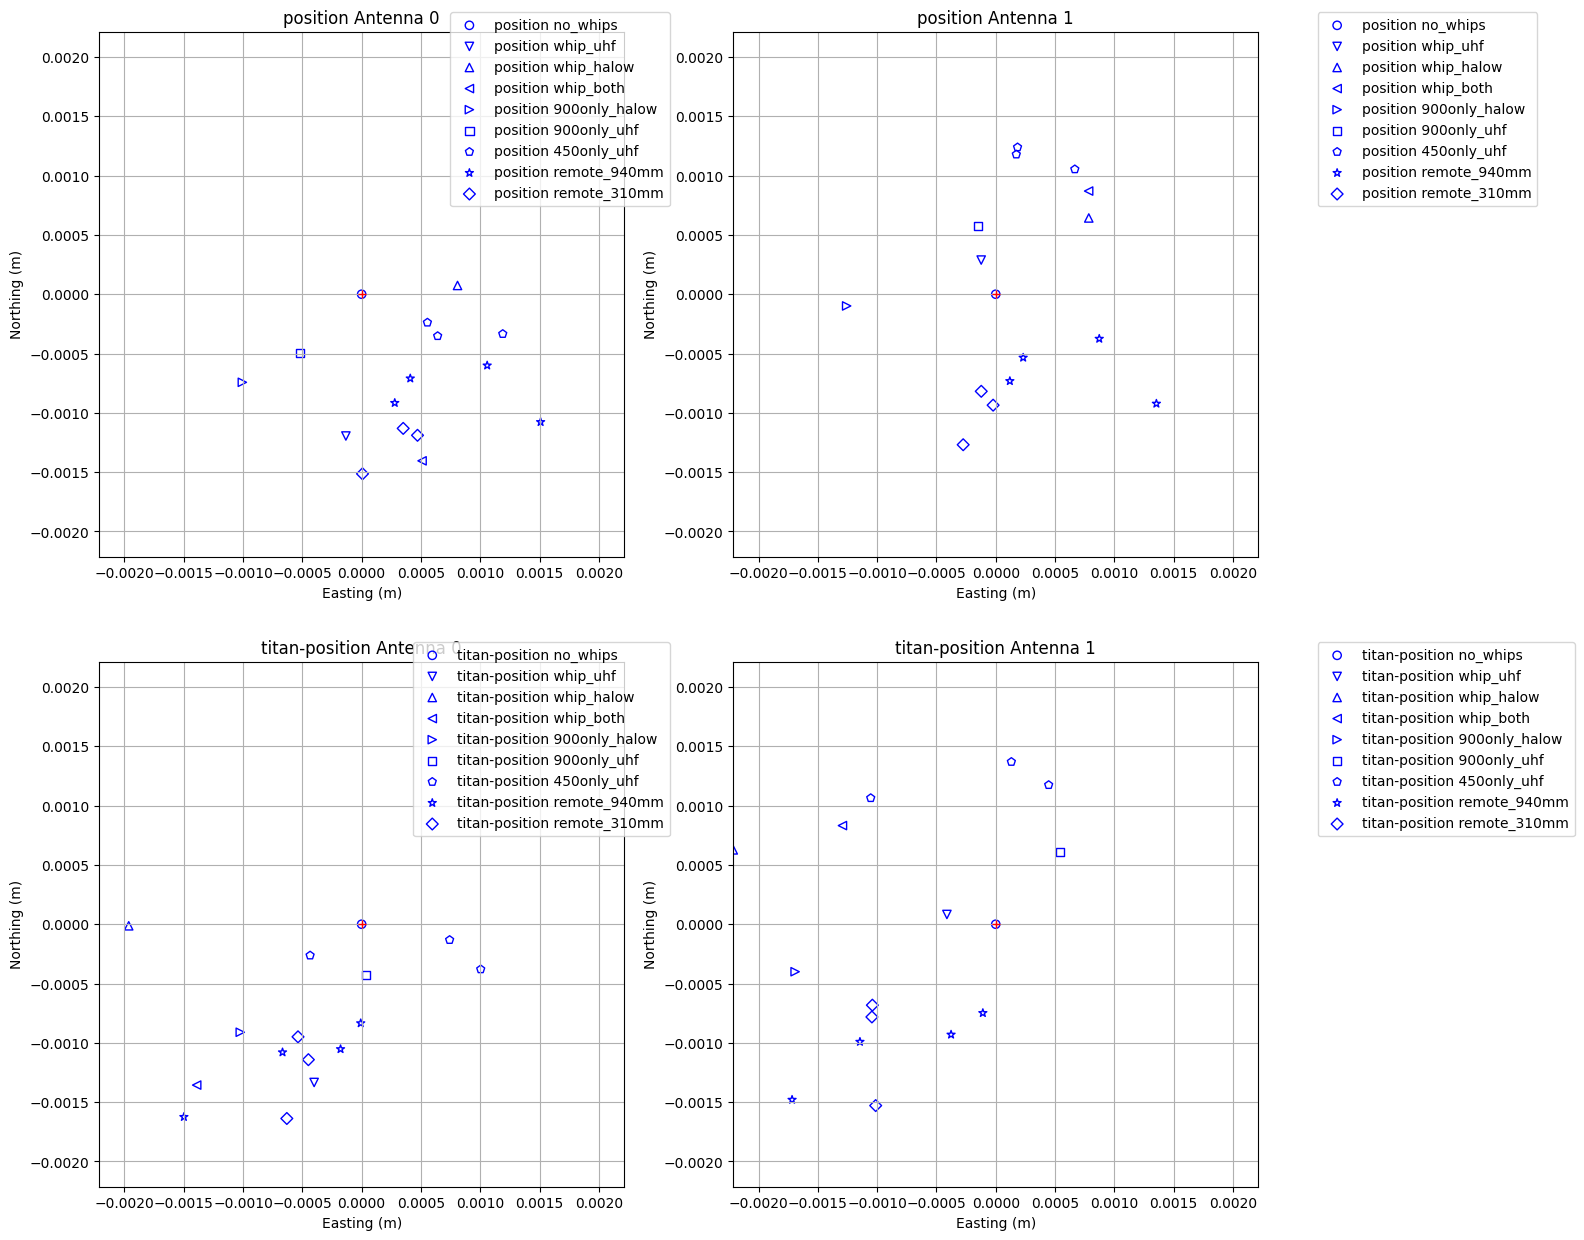

In [225]:
max_ne = np.max(np.array([df.northing.abs().max(), df.easting.abs().max()]))
fig, ax = plt.subplots(len(data_types), 2, 
                       #layout="constrained",
                       figsize=(15, 15),
                      )
for ant in [0, 1]:
    for dt_n, dt in enumerate(data_types):
        for d in df.descr.unique():
            dfq = df.query(f'antenna=={ant} and data_type=="{dt}" and descr=="{d}"')
            if dfq.empty:
                continue
            
            ax[dt_n, ant].scatter(dfq.easting, dfq.northing, 
                            marker=marker_map[d],
                            facecolors='none',
                            #c='b',
                            edgecolor='b',
                            label= f'{dt} {d}',
                           )
        ax[dt_n, ant].plot(0, 0, 'r+')    
        ax[dt_n, ant].set_xlim([-max_ne, max_ne])
        ax[dt_n, ant].set_ylim([-max_ne, max_ne])
        ax[dt_n, ant].set_box_aspect(1)
        ax[dt_n, ant].set_ylabel('Northing (m)')
        ax[dt_n, ant].set_xlabel('Easting (m)')
        ax[dt_n, ant].legend(bbox_to_anchor=(1.1, 1.05))
        ax[dt_n, ant].set_title(f'{dt} Antenna {ant}')
        ax[dt_n, ant].grid(True)

plt.savefig('figures/position_notebook_horiz.png')

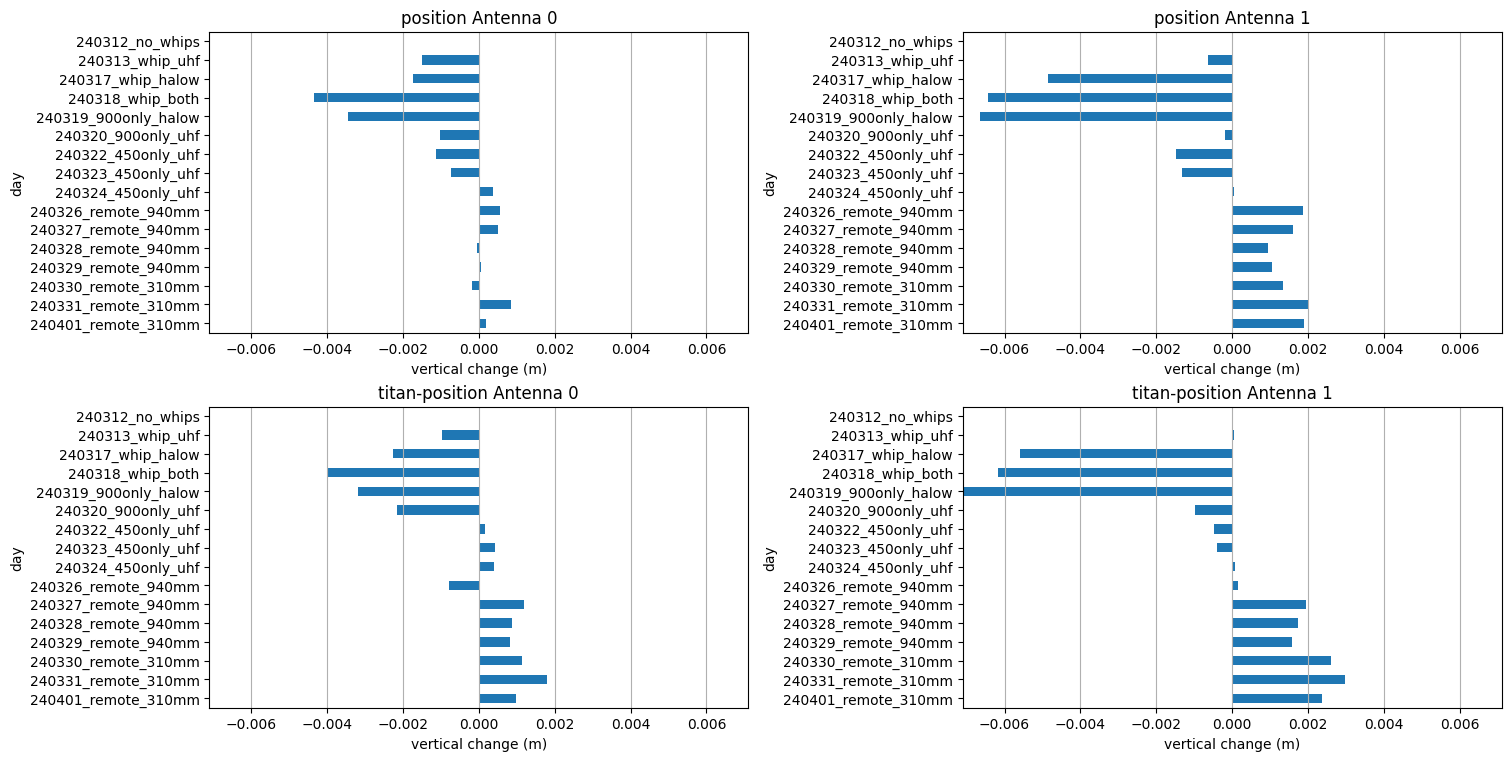

In [302]:
max_vert = df.up.abs().max()
fig, ax = plt.subplots(len(data_types), 2, 
                       layout="constrained",
                       figsize=(15, 7.5),
                      )

for ant in [0, 1]:
    for dt_n, dt in enumerate(data_types): 
        dfq = df.query(f'antenna=={ant} and data_type=="{dt}"') # and descr=="{d}"')
       
        #if dfq.empty:
        #    continue
        #display(dfq[['day', 'descr', 'antenna', 'up']])
        #break
        #dfg = dfq.groupby(['descr']).up
                 #marker=marker_map[d],
                 #label= f'{dt} {d}',
                #)
        # .unstack().plot.bar(ax=ax[ant],
        #dfg.plot.bar(ax=ax[dt_n, ant])
        #ax[dt_n, ant].bar(dfq.day_n, dfq.up, label=dfq.day) 
        dfq.plot.barh('day', 'up', ax=ax[dt_n, ant], legend=False)
        ax[dt_n, ant].invert_yaxis()
        ax[dt_n, ant].set_xlim([-max_vert, max_vert])
        ax[dt_n, ant].set_xlabel('vertical change (m)')
        ax[dt_n, ant].set_title(f'{dt} Antenna {ant}')
        ax[dt_n, ant].grid(axis='x')

plt.savefig('figures/position_notebook_vert.png')

# Read Weighted Mean and Heading CSVs

In [56]:
#aps.do_summary('.', days=None, titan_separate=True, truth_csv='P3ENCL_position_truth.csv'),
#               #data_out_dir, fig_dir, verbose,
folder = '.'
devs = ['P3ENCL-all']

html_list, uptime_list, weighted_pos_list = aps.get_file_lists(folder, 'gen_data', 'figures')
#print(uptime_list)

data_types = ['position', 'titan-position']
days = gutil.get_days(folder, None)

#dir_list = gutil.get_dev_list(folder, days, 'gen_data', devs)

df_list = []
for dt in data_types:
    uptime_list = []
    weighted_pos_list = []
    for dev in devs:
        truth_csv = f'{dev}_{dt}_truth.csv'
        print(f'{truth_csv=}', os.path.isfile(truth_csv))
        for day in days:
            uptime_f = os.path.join(folder, day, 'gen_data', dt, dev, f'{dev}_pos_uptime.csv')
            #print(uptime_f)
            if os.path.isfile(uptime_f):
                #print(f'Found {uptime_f}')
                uptime_list.append(uptime_f)

            w_pos_f = os.path.join(folder, day, 'gen_data', dt, dev, f'{dev}_pos_weighted_stats.csv')
            #print(uptime_f)
            if os.path.isfile(w_pos_f):
                #print(f'Found {w_pos_f}')
                weighted_pos_list.append(w_pos_f)

        df_heading = aps.heading_summary(uptime_list)
        df_heading = df_heading.rename({'dut':'dev'}, axis='columns')
        df_w_pos = aps.w_pos_summary(weighted_pos_list, truth_csv)
        print(list(df_w_pos.columns))
        df = merge_heading_wpos(df_w_pos, df_heading)
        df_list.append(df)
        #print(df.shape)
df = pd.concat(df_list)
display(df)
print(list(df.columns))

truth_csv='P3ENCL-all_position_truth.csv' True
['day', 'dev', 'data_type', 'antenna', 'w_mean_lat', 'w_mean_lon', 'w_mean_hgt', 'std_err', 'std_err_hprec', 'std_err_vprec', 'count', 'datum', 'datum_epoch', 'northing', 'easting', 'up', 'comments']
truth_csv='P3ENCL-all_titan-position_truth.csv' True
['day', 'dev', 'data_type', 'antenna', 'w_mean_lat', 'w_mean_lon', 'w_mean_hgt', 'std_err', 'std_err_hprec', 'std_err_vprec', 'count', 'datum', 'datum_epoch', 'northing', 'easting', 'up', 'comments']


day         dev       data_type  antenna  w_mean_lat  \
0         240312_no_whips  P3ENCL-all        position        0   39.896468   
1         240312_no_whips  P3ENCL-all        position        1   39.896467   
0   240312_no_whips_short  P3ENCL-all        position        0   39.896468   
1   240312_no_whips_short  P3ENCL-all        position        1   39.896467   
0         240313_whip_uhf  P3ENCL-all        position        0   39.896468   
..                    ...         ...             ...      ...         ...   
1     240330_remote_310mm  P3ENCL-all  titan-position        1   39.896472   
0     240331_remote_310mm  P3ENCL-all  titan-position        0   39.896473   
1     240331_remote_310mm  P3ENCL-all  titan-position        1   39.896472   
0     240401_remote_310mm  P3ENCL-all  titan-position        0   39.896473   
1     240401_remote_310mm  P3ENCL-all  titan-position        1   39.896472   

    w_mean_lon   w_mean_hgt   std_err  std_err_hprec  std_err_vprec    count  \
0  -105.115056  1668.524142  0.023233       0.004582       0.010636  86857.0   
1  -105.115056  1668.527233  0.007273       0.002102       0.002264  86857.0   
0  -105.115056  1668.524981  0.095892       0.003786       0.008665   3600.0   
1  -105.115056  1668.528486  0.034494       0.002063       0.002085   3600.0   
0  -105.115056  1668.522656  0.021217       0.004233       0.009555  87518.0   
..         ...          ...       ...            ...            ...      ...   
1  -105.115071  1667.624826  0.007505       0.002549       0.003459  86397.0   
0  -105.115071  1667.628259  0.021739       0.016337       0.028931  86400.0   
1  -105.115071  1667.625198  0.007564       0.002503       0.003133  86397.0   
0  -105.115071  1667.627436  0.021787       0.015719       0.027847  86400.0   
1  -105.115071  1667.624575  0.007599       0.002459       0.003064  86397.0   

     datum  datum_epoch      northing       easting            up comments  \
0   WGS-84          0.0 -3.531454e-09  1.414450e-08  3.865352e-12            
1   WGS-84          0.0  3.531454e-09  2.720096e-08 -9.094947e-13            
0   WGS-84          0.0  4.713432e-05 -1.542033e-03  8.389922e-04            
1   WGS-84          0.0  7.931999e-05 -1.577248e-03  1.253432e-03            
0   WGS-84          0.0 -1.195531e-03 -1.329398e-04 -1.486714e-03            
..     ...          ...           ...           ...           ...      ...   
1      NaN          NaN -7.819472e-04 -1.044207e-03  2.607660e-03            
0      NaN          NaN -1.638008e-03 -6.309566e-04  1.802715e-03            
1      NaN          NaN -1.529279e-03 -1.012383e-03  2.979308e-03            
0      NaN          NaN -9.493890e-04 -5.366890e-04  9.795787e-04            
1      NaN          NaN -6.824393e-04 -1.040246e-03  2.356946e-03            

    heading_mean  
0       1.359880  
1       1.359880  
0       1.386860  
1       1.386860  
0       1.379091  
..           ...  
1       1.841732  
0       1.675777  
1       1.675777  
0       1.770880  
1       1.770880  

[66 rows x 18 columns]

['day', 'dev', 'data_type', 'antenna', 'w_mean_lat', 'w_mean_lon', 'w_mean_hgt', 'std_err', 'std_err_hprec', 'std_err_vprec', 'count', 'datum', 'datum_epoch', 'northing', 'easting', 'up', 'comments', 'heading_mean']


# Plot Functions

In [6]:
def truth_plot(df):
    if not 'northing' in df:
        return

    lim_max = np.max(np.array([df.northing.abs().max(),
                               df.easting.abs().max()])) * 1.1

    ant_list = list(df.antenna.unique())
    N_ant = len(ant_list)
    dev_list = list(df.dev.unique())
    N_dev = len(dev_list)
    fig, ax = plt.subplots(len(dev_list), N_ant,
                           figsize=(9, N_dev*4),
                           layout="constrained",
                           )
    for row_index, row in df.iterrows():
        #print(row.dev, row.antenna, row.day, row.data_type, row.easting, row.northing)
        n_dev = dev_list.index(row.dev)
        n_ant = ant_list.index(row.antenna)
        #print(n_dev, n_ant, row.easting, row.northing)
        ax[n_dev, n_ant].plot(row.easting, row.northing, 'bx',
                         label=f'{row.day} {row.data_type}', 
                         )
    for n_dev, dev in enumerate(dev_list):
        dfq = df.query(f'dev=="{dev}"')
        lim_max = np.max(np.array([dfq.northing.abs().max(),
                               dfq.easting.abs().max()])) * 1.1
        ax[n_dev, 0].set_ylabel(f'{dev}\nNorthing (m)')
        for n_ant, antenna in enumerate(ant_list):
            ax[n_dev, n_ant].plot(0, 0, 'r+')
            ax[N_dev-1, n_ant].set_xlabel('Easting (m)')
            ax[0, n_ant].set_title(f'Antenna {antenna}')
            ax[n_dev, n_ant].set_xlim([-lim_max, lim_max])
            ax[n_dev, n_ant].set_ylim([-lim_max, lim_max])
            ax[n_dev, n_ant].set_box_aspect(1)
            #ax[n_dev, n_ant].legend(bbox_to_anchor=(1.1, 1.05))

ValueError: s must be a scalar, or float array-like with the same size as x and y

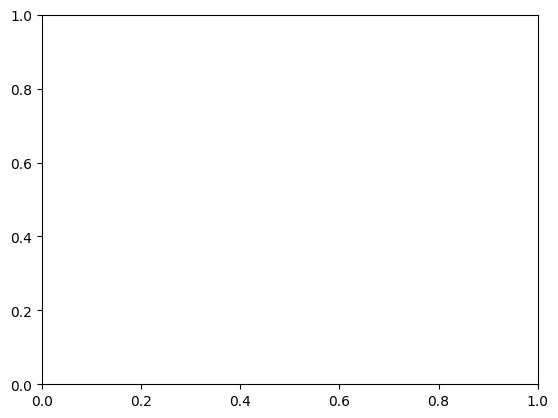

In [5]:
df_p3.query('antenna==0').plot.scatter('easting', 'northing', 
           #kind='scatter',
           marker='o', 
           s=df_p3.std_err_hprec * 100,
          )